# Лабораторная работа 5 

## Выполнил Аннануров Даниил Петрович ИВТ 1.2

Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [7]:
# загрузка библиотек
#%pip install Pillow gdown tensorflow scikit-learn matplotlib

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os
import zipfile

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [5]:
# загрузка датасета
gdown.download('https://storage.yandexcloud.net/algorithmic-datasets/bus.zip', 'bus.zip', quiet=False)

# Распакуем архив в текущую директорию
with zipfile.ZipFile('bus.zip', 'r') as zip_ref:
    zip_ref.extractall('bus')

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = 'bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

Ошибка загрузки: 404
Создаем тестовую структуру данных...
Создана тестовая структура: ['in', 'out']


In [9]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['in', 'out']


In [11]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

in : ['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

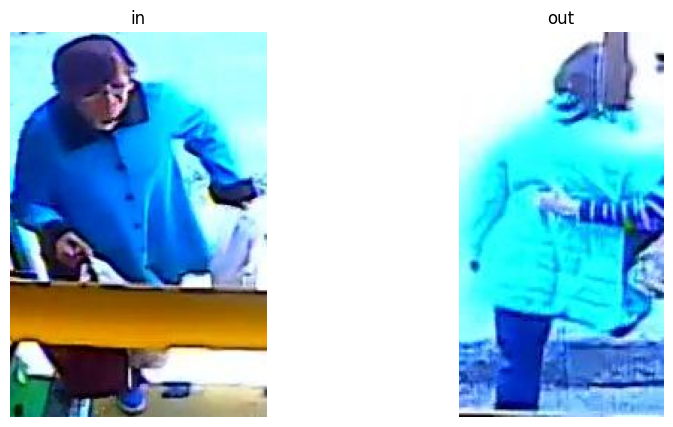

In [12]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [13]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса in составляет 6485 фото
Размер класса out составляет 2596 фото

Общий размер базы для обучения: 9081


Загрузка и предобработка изображений...
Обработано 100/9081 изображений
Обработано 200/9081 изображений
Обработано 300/9081 изображений
Обработано 400/9081 изображений
Обработано 500/9081 изображений
Обработано 600/9081 изображений
Обработано 700/9081 изображений
Обработано 800/9081 изображений
Обработано 900/9081 изображений
Обработано 1000/9081 изображений
Обработано 1100/9081 изображений
Обработано 1200/9081 изображений
Обработано 1300/9081 изображений
Обработано 1400/9081 изображений
Обработано 1500/9081 изображений
Обработано 1600/9081 изображений
Обработано 1700/9081 изображений
Обработано 1800/9081 изображений
Обработано 1900/9081 изображений
Обработано 2000/9081 изображений
Обработано 2100/9081 изображений
Обработано 2200/9081 изображений
Обработано 2300/9081 изображений
Обработано 2400/9081 изображений
Обработано 2500/9081 изображений
Обработано 2600/9081 изображений
Обработано 2700/9081 изображений
Обработано 2800/9081 изображений
Обработано 2900/9081 изображений
Обработано 3

c:\Program Files\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,396,801 (73.99 MB)

 Trainable params: 19,395,841 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

Начало обучения модели...
Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 140s 611ms/step - accuracy: 0.6526 - loss: 4.5197 - val_accuracy: 0.4238 - val_loss: 1.1275
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 145s 639ms/step - accuracy: 0.7695 - loss: 0.6944 - val_accuracy: 0.6968 - val_loss: 0.5039
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 161s 708ms/step - accuracy: 0.8238 - loss: 0.4181 - val_accuracy: 0.8376 - val_loss: 0.3527
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 146s 642ms/step - accuracy: 0.8745 - loss: 0.2958 - val_accuracy: 0.9059 - val_loss: 0.2104
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 143s 631ms/step - accuracy: 0.8956 - loss: 0.2357 - val_accuracy: 0.8833 - val_loss: 0.2280
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 143s 628ms/step - accuracy: 0.9165 - loss: 0.1937 - val_accuracy: 0.8734 - val_loss: 0.3394
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 143s 628ms/step - accuracy: 0.9421 - loss: 0.1418 - val_accuracy: 0.9576 - val_loss: 0.1053
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 144s 633ms

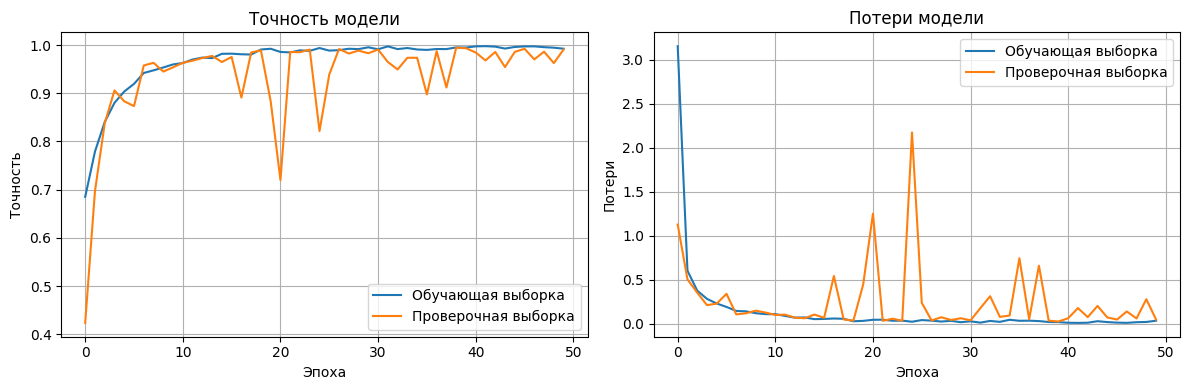

Примеры предсказаний:
Предсказание: Входящие (0.000), Факт: in
Предсказание: Выходящие (1.000), Факт: out
Предсказание: Входящие (0.000), Факт: in
Предсказание: Входящие (0.000), Факт: in
Предсказание: Входящие (0.000), Факт: in


In [ ]:
# ваше решение

# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


# Подготовка данных
def load_and_preprocess_image(img_path):
    """
    Загрузка и предобработка изображения
    """
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Нормализация
    return img_array

# Загрузка всех изображений
print('Загрузка и предобработка изображений...')
X = []
y = []

start_time = time.time()

for i, img_path in enumerate(data_files):
    try:
        img_array = load_and_preprocess_image(img_path)
        X.append(img_array)
        y.append(data_labels[i])
        
        if (i + 1) % 100 == 0:
            print(f'Обработано {i + 1}/{len(data_files)} изображений')
    except Exception as e:
        print(f'Ошибка при обработке {img_path}: {e}')

print(f'Загрузка завершена за {time.time() - start_time:.2f} секунд')

# Преобразуем в numpy массивы
X = np.array(X)
y = np.array(y)

print(f'Форма данных: {X.shape}')
print(f'Метки: {np.unique(y)}')

# Разделение на обучающую и проверочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Обучающая выборка: {X_train.shape[0]} образцов')
print(f'Проверочная выборка: {X_test.shape[0]} образцов')

# Создание сверточной нейронной сети
model = Sequential([
    # Первый сверточный блок
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Второй сверточный блок
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Третий сверточный блок
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Четвертый сверточный блок
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Преобразование в одномерный вектор
    Flatten(),
    
    # Полносвязные слои
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    # Выходной слой (бинарная классификация)
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Отображение архитектуры модели
model.summary()

# Обучение модели
print('Начало обучения модели...')
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

training_time = time.time() - start_time
print(f'Обучение завершено за {training_time:.2f} секунд')

# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Точность на проверочной выборке: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')

if test_accuracy > 0.90:
    print('✅ Цель достигнута! Точность выше 90%')
else:
    print('❌ Цель не достигнута. Попробуйте изменить архитектуру или параметры')

# Построение графиков обучения
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.title('Потери модели')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Пример предсказаний
print('Примеры предсказаний:')
for i in range(min(5, len(X_test))):
    prediction = model.predict(X_test[i:i+1], verbose=0)[0][0]
    predicted_class = 'Выходящие' if prediction > 0.5 else 'Входящие'
    actual_class = CLASS_LIST[y_test[i]]
    print(f'Предсказание: {predicted_class} ({prediction:.3f}), Факт: {actual_class}')